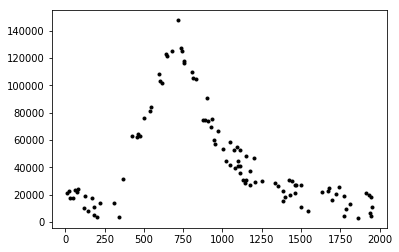

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as cp

def expf(t,a,b):
    return np.exp(a*(t-b))

def linef(t, x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    b = y2 - (m*x2)
    return ((m*t)+b)



def PW_Model(t, params):
        result = np.empty(len(t))
        for i in range(len(t)): #had to tweak this to accept t-arrays, may affect speed...
            if(t[i]<params[0]):
                result[i] = expf(t[i], params[2], params[3])
            elif(params[0]<=t[i] and t[i]<=params[1]):
                result[i] = linef(t[i], params[0], expf(params[0], params[2], params[3]), params[1], expf(params[1], params[4], params[5]))
            elif(params[1]<t[i]):
                result[i] = expf(t[i], params[4], params[5])
        return result
    
parameter_names = ("xc", "al", "bl", "ar", "br")
    
def DExp_Model(t):
    result = np.empty(len(t))
    for i in range(len(t)): #had to tweak this to accept t-arrays, may affect speed...
        if(t[i]<params[0]):
            result[i] = expf(t[i], params[1], params[2])
        elif(params[0]<t[i]):
            result[i] = expf(t[i], params[3], params[4])
    return result

    
def simulate(N, params, model, yerrsize = 25000, bounds=(0,2000)):
    x = (np.random.rand(N) * (bounds[1]-bounds[0])) + bounds[0]
    y = model(x, params)
    yerr = np.random.rand(N) * yerrsize
    y += yerr
    return x, y

params0 = [4.08344998e+02, 7.15585975e+02, 4.26056582e-02, 1.61781302e+02, -3.64834836e-03, 3.94850711e+03]
x,y = simulate(100, params0, PW_Model)

plt.plot(x,y, 'k.')
plt.show()